# Inference of parameters with latent variables (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the epidemiological parameters as well as control parameters from the $I_\mathrm{s}$ trajectory. 

For the pre-intervention period, we infer the following parameters as well as initial conditions: 
* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

For the post-intervention period, we infer the following control parameters: 
* $a_\mathrm{W}$ fraction of work contact, 
* $a_\mathrm{S}$ fraction of social contact, 
* $a_\mathrm{O}$ fraction of other contacts 

In [1]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1) Generate a trajectory
We generate a test trajectory on a population with four ages groups using UK contact matrix

In [2]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]
        
print(N)

64111602.0


In [3]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

# Set intervention time, and the total length for the trajectory 
T_intervention = 100 # intervention time 
Tf = 600
Nf = Tf+1

# a tanh function for intervention 
def approx_tanh(t, width, loc):
    cond1 = (t < loc-width/2)
    cond2 = (t >= loc+width/2)
    cond3 = np.logical_and((t < loc+width/2), (t >= loc-width/2))
    cond_list = [cond1, cond2, cond3]
    fun_list = [-1, 1, lambda t: 2*(t-loc)/width]
    return np.piecewise(t, cond_list, fun_list)
    
def intervention_fun(t, M, width=1, loc=0, aW_f=0, aS_f=0, aO_f=0):
    aW = (1-approx_tanh(t, width, loc))/2*(1-aW_f) + aW_f
    aS = (1-approx_tanh(t, width, loc))/2*(1-aS_f) + aS_f
    aO = (1-approx_tanh(t, width, loc))/2*(1-aO_f) + aO_f
    aW_full = np.full((2, M), aW) # must return the full (2, M) array 
    aS_full = np.full((2, M), aS)
    aO_full = np.full((2, M), aO)
    return aW_full, aS_full, aO_full

In [4]:
beta  = 0.02      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.2              # asymptomatic fraction
fsa   = 1               # suppresion of contact by symptomatics


# initial conditions    
Is0 = np.zeros(M)
Is0[1] = 10 
Ia0 = np.zeros((M))
R0  = np.zeros((M))
S0  = Ni - (Ia0 + Is0 + R0)

# contact matrix 
width = 10 
loc = T_intervention 
aW_f = 0.9
aS_f = 0.8 
aO_f = 0.8 
contactMatrix = generator.intervention_custom_temporal(intervention_fun, 
                                                       width=width, loc=loc, 
                                                       aW_f=aW_f, aS_f=aS_f, aO_f=aO_f)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SIR(parameters, M, Ni)

# start simulation
Tf=600;  Nf=Tf+1 
data=model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau-leaping')
np.save('cal_lat_SIR_traj.npy', data['X'])

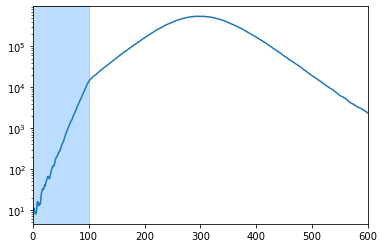

In [5]:
# plot the number of infected people 
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.semilogy(t, IC)
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.show() 

## 2) Infer the parameters and initial conditions for the pre-intervention trajectory

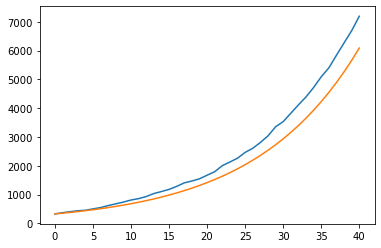

In [6]:
N_start = 50 
Tf_initial = 40 # truncate to only getting the pre-intervention trajectory 
Nf_initial = Tf_initial+1

x = (np.load('cal_lat_SIR_traj.npy')).astype('float')
x = x[N_start:N_start+Nf_initial]

# a filter that yields the Is only 
fltr = np.kron([0, 0, 1],np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
x0 = x[0] 

steps = 4 # number of steps 
estimator = pyross.inference.SIR(parameters, M, Ni, 1, steps)

# Check the deterministic simulation against stochstic simulations with the same parameters and initial conditons 
# They are likely to be different due to the inherent stochasticity of the model 

estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
xm = estimator.integrate(x0, 0, Tf_initial, Nf_initial)
t = np.linspace(0, Tf_initial, Nf_initial)
plt.plot(t, np.sum(x[:,2*M:3*M], axis=1))
plt.plot(t, np.sum(xm[:,2*M:3*M], axis=1))
plt.show()

In [7]:
# Compute -log_p for the original (correct) parameters 
# This gives an estimate of the final -logp we expect from the optimisation scheme 
start_time = time.time() 
parameters = {'alpha': alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_initial, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

622.3399364376057
0.04822206497192383


In [8]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3 

eps=1e-4
param_priors = {
    'alpha':{
        'mean': 0.2, 
        'std': 0.05, 
        'bounds': [eps, 0.5]
    },
    'beta':{
        'mean': 0.04, 
        'std': 0.1,
        'bounds': [eps, 0.4]
    }, 
    'gIa':{
        'mean': 0.13, 
        'std': 0.05, 
        'bounds': [eps, 0.3]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 0.3]
    }
}

Ia0_g = x0[M:2*M]
Ia_std = Ia0_g*2
bounds_for_Ia = np.tile([0.1, N], M).reshape(M, 2)

S0_g = x0[:M]
S_std = Ia_std*2
bounds_for_S = np.tile([0.1, N], M).reshape(M, 2)

init_fltr = np.repeat([True, True, False], M)

init_priors = {
    'independent':{
        'fltr': init_fltr, 
        'mean': [*S0_g, *Ia0_g], 
        'std': [*S_std, *Ia_std], 
        'bounds': [*bounds_for_S, *bounds_for_Ia]
    }
}


# Optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

start_time = time.time()
res = estimator.latent_infer_parameters(obs, fltr, Tf_initial, contactMatrix, param_priors, init_priors, 
                                        tangent=True, global_max_iter=30, global_atol=1, verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 12 (seed=3419665837, Mon Jul  6 13:26:29 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 3.050029988214789e+03 1.0e+00 9.46e-01  5e-02  1e+02 0:00.5
    2     32 9.176117922602954e+02 1.2e+00 8.86e-01  4e-02  1e+02 0:01.0
    3     48 1.296605607933399e+04 1.3e+00 8.54e-01  4e-02  1e+02 0:01.4
   11    176 6.953947728329681e+02 1.9e+00 7.58e-01  4e-02  1e+02 0:04.7
   21    336 9.998820057842044e+02 2.7e+00 9.29e-01  4e-02  1e+02 0:08.9
   30    480 9.237519640838110e+02 3.1e+00 1.08e+00  5e-02  1e+02 0:14.0
Optimal value (global minimisation):  656.6071964341588
Starting local minimisation...
Optimal value (local minimisation):  649.603510019008
20.20119309425354


In [9]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

best_estimates = res['map_params_dict']
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(x0.astype('int'))


map_x0 = res['map_x0']
print('\n Inferred initial conditons: ') 
print(map_x0.astype('int'))

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

 Best estimates
{'alpha': 0.16961875588464387, 'beta': 0.016729553400864898, 'gIa': 0.11559766734854754, 'gIs': 0.10634561036933893, 'fsa': array([1., 1., 1., 1.])}

 True initial conditions: 
[15634137 17833760 17762697 12879802       18       33       24       10
       85      124       87       34]

 Inferred initial conditons: 
[15634132 17833743 17762676 12879802       97        0       17        2
       85      124       87       34]


In [10]:
logp = estimator.minus_logp_red(best_estimates, map_x0, obs, fltr, Tf_initial, contactMatrix, tangent=True)
print(logp)

620.1103269813384


### Check the inferred trajectory against the true trajectory for pre-intervention

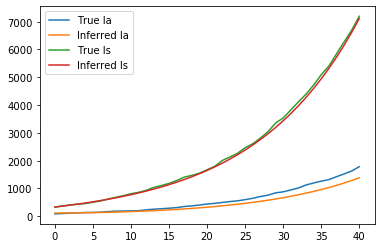

In [11]:
x = np.load('cal_lat_SIR_traj.npy')[N_start:N_start+Nf_initial]

# set params for estimate
estimator.set_params(best_estimates)

# make det_model and contactMatrix 
estimator.set_det_model(best_estimates)

# generate the deterministic trajectory 
estimator.set_det_method('LSODA')
x_det = estimator.integrate(map_x0, 0, Tf_initial, Nf_initial)
plt.plot(np.sum(x[:Nf_initial,M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:Nf_initial,2*M:3*M], axis=1), label='True Is')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.legend()
plt.show()

Quite good at inferring Is (which it can see), not so good at inferring Ia (which it cannot see)

## 3) Infer the control parameters 
We infer the control parameters, including the location of change, width and the final aW, aS, aO 

In [12]:
# Test the -logp for the correct control parameters 

# get the trajectory 
x = np.load('cal_lat_SIR_traj.npy').astype('float')
x = x[N_start:T_intervention+20]
obs = np.einsum('ij,kj->ki', fltr, x)
Nf_inference = x.shape[0] 
Tf_inference = Nf_inference-1 


contactMatrix = generator.intervention_custom_temporal(intervention_fun, 
                                                       width=width, loc=loc-N_start, 
                                                       aW_f=aW_f, aS_f=aS_f, aO_f=aO_f)
# compute -log_p 
estimator.set_params(best_estimates)
logp = estimator.minus_logp_red(best_estimates, x[0], obs, fltr, Tf_inference, contactMatrix, tangent=True)
print(logp) 

1252.894779570896


In [13]:
param_priors = {
    'width':{
        'mean': 10,
        'std': 5, 
        'bounds': [1e-3, 40]
    }, 
    'loc':{
        'mean': T_intervention-N_start, 
        'std': 10, 
        'bounds': [T_intervention-100, T_intervention+100]
    }, 
    'aW_f':{
        'mean': 0.8, 
        'std': 0.2, 
        'bounds': [0.1, 1.0]
    }, 
    'aS_f':{
        'mean': 0.8, 
        'std': 0.1, 
        'bounds': [0.1, 1.0]
    }, 
    'aO_f':{
        'mean': 0.8, 
        'std': 0.1, 
        'bounds': [0.1, 1.0]
    }
}

Ia0_g = map_x0[M:2*M]
Ia_std = Ia0_g
bounds_for_Ia = np.tile([0.1, N], M).reshape(M, 2)

S0_g = map_x0[:M]
S_std = Ia_std*2
bounds_for_S = np.tile([0.1, N], M).reshape(M, 2)

init_fltr = np.repeat([True, True, False], M)

init_priors = {
    'independent':{
        'fltr': init_fltr, 
        'mean': [*S0_g, *Ia0_g], 
        'std': [*S_std, *Ia_std], 
        'bounds': [*bounds_for_S, *bounds_for_Ia]
    }
}



start_time = time.time() 
res = estimator.latent_infer_control(obs, fltr, Tf_inference, generator, param_priors, init_priors,  
                                                 intervention_fun=intervention_fun, tangent=True,
                                                 global_max_iter=30, verbose=True)
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 13 (seed=1288948666, Mon Jul  6 13:26:49 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.391319596156616e+03 1.0e+00 9.33e-01  9e-02  2e+02 0:00.8
    2     32 1.305937147670395e+03 1.2e+00 9.12e-01  9e-02  2e+02 0:01.5
    3     48 1.302718376772252e+03 1.2e+00 8.92e-01  9e-02  2e+02 0:02.6
    6     96 1.335164575025875e+03 1.5e+00 7.68e-01  7e-02  1e+02 0:05.8
    9    144 1.271320435259297e+03 1.6e+00 7.01e-01  6e-02  1e+02 0:09.8
   17    272 1.257236794455322e+03 2.2e+00 5.72e-01  4e-02  1e+02 0:14.9
   27    432 1.254240502737656e+03 3.0e+00 3.39e-01  2e-02  6e+01 0:21.3
Optimal value (global minimisation):  1247.3851290820796
Starting local minimisation...
Optimal value (local minimisation):  1243.8814229498753
29.587646007537842


In [14]:
true_control_params = {'width': width, 'loc': T_intervention-N_start, 'aW_f': aW_f, 'aS_f': aS_f, 'aO_f': aO_f}
inferred_control_params = res['map_params_dict']

print('True control params:')
print(true_control_params)

print('\n Inferred control params:')
print(inferred_control_params)

True control params:
{'width': 10, 'loc': 50, 'aW_f': 0.9, 'aS_f': 0.8, 'aO_f': 0.8}

 Inferred control params:
{'width': 9.33827097010135, 'loc': 50.37040878761407, 'aW_f': 0.8743870517486457, 'aS_f': 0.786768950712863, 'aO_f': 0.7703267962094683}


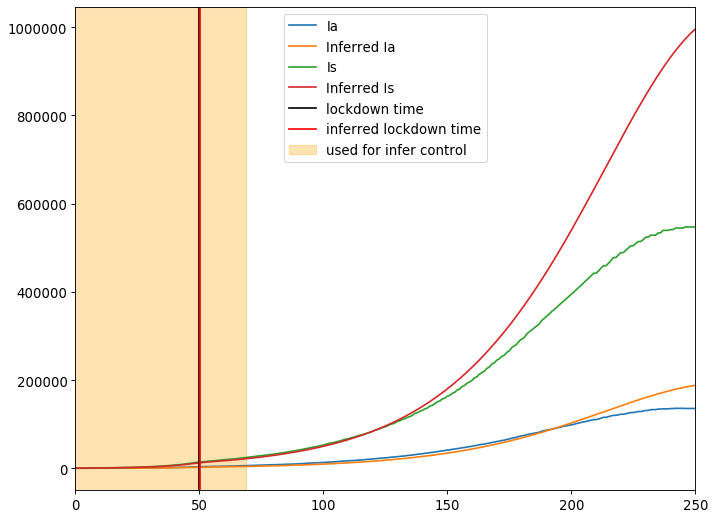

In [15]:
# compare the true trajectory with the original one 
Tf = 300 - N_start
Nf = Tf + 1 

inferred_contactMatrix = generator.intervention_custom_temporal(intervention_fun, **inferred_control_params)
loc = inferred_control_params['loc']
                                                 
estimator.set_det_model(best_estimates)
estimator.set_contact_matrix(inferred_contactMatrix)
x_det_control = estimator.integrate(x0, 0, Tf, Nf)
x = np.load('cal_lat_SIR_traj.npy')[N_start:]
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
plt.plot(np.sum(x[:,M:2*M], axis=1), label='Ia')
plt.plot(np.sum(x_det_control[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:,2*M:3*M], axis=1), label='Is')
plt.plot(np.sum(x_det_control[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.axvline(x=T_intervention-N_start, label='lockdown time', color='black')
plt.axvline(x=loc, label='inferred lockdown time', color='red')
plt.axvspan(0, Tf_inference, 
           label='used for infer control',
           alpha=0.3, color='orange')
plt.xlim([0, Tf])
plt.legend()
plt.show()